In [22]:
import lance
#from lance import LanceFileFormat
import pyarrow as pa
import numpy as np
import pandas as pd
import rawpy
from pathlib import Path
import duckdb
import pyarrow.dataset as ds
import matplotlib.pyplot as plt

In [3]:
path = Path('/home/ubuntu/pen')

In [4]:
#images = path / 'images'
images = path
print(images)

/home/ubuntu/pen


In [5]:
images = path.glob('**/*')
#print([str(i) for i in images.ls()])
file_names = [str(x) for x in images if x.is_file()]

In [6]:
print(file_names)

['/home/ubuntu/pen/pen_20230208_155135.dng', '/home/ubuntu/pen/pen_20230208_155005.dng', '/home/ubuntu/pen/pen_20230208_155059.dng', '/home/ubuntu/pen/20230208_155149.dng', '/home/ubuntu/pen/20230208_155119.dng', '/home/ubuntu/pen/20230208_155152.dng', '/home/ubuntu/pen/pen_20230208_155112.dng', '/home/ubuntu/pen/20230208_155126.dng', '/home/ubuntu/pen/pen_20230208_155031.dng', '/home/ubuntu/pen/20230208_155001.dng', '/home/ubuntu/pen/pen_20230208_155041.dng', '/home/ubuntu/pen/pen_20230208_155145.dng', '/home/ubuntu/pen/pen_20230208_155049.dng']


In [7]:
#lambda to get class from file_name
is_pen = lambda x : "pen" if "pen_" in x else "no_pen"

In [8]:
records = []
for file_name in file_names:
    with rawpy.imread(file_name) as raw:
        records.append({
            "file_name": file_name,
            "bytes": raw.raw_image.tobytes(),
            "class": is_pen(file_name)
        })
#TODO: brute force writing bytes from rawpy raw image -> can read with from buffer numpy
#TODO: fix filenames -> does not make sense atm

In [9]:
table = pa.Table.from_pylist(records)

In [10]:
lance.write_dataset(table, 's3://lance-demo/pen_ds.lance', mode='overwrite')

In [11]:
uri ="s3://lance-demo/pen_ds.lance"
pen_ds = lance.dataset(uri)
print(pen_ds.schema.names)

['file_name', 'bytes', 'class']


In [12]:
#tbl = pen_ds.to_table()  # next release of duckdb will have pushdowns enabled
#duckdb.query("SELECT * FROM tbl LIMIT 10").to_df()

In [13]:
pen_ds_names = pen_ds.scanner(columns=["file_name", "class"])

In [14]:
duckdb.query("""
WITH objects AS (SELECT file_name, class FROM pen_ds_names)
SELECT class, count(file_name) as count
FROM objects
GROUP BY 1
ORDER BY 2 DESC
""").to_df()

,class,count
0,pen,8
1,no_pen,5


In [18]:
#load pens
pen_bytes = pen_ds.scanner(columns=["bytes", "class"])
#very fast

In [19]:
df = duckdb.query("""
SELECT bytes
FROM pen_bytes
WHERE class='pen'
LIMIT 2;
""").to_df()
#kind of slow

Widget Javascript not detected.  It may not be installed or enabled properly.


In [21]:
df.head()

,bytes
0,"[141, 0, 148, 0, 162, 0, 108, 0, 203, 0, 83, 0..."
1,"[32, 0, 14, 0, 14, 0, 16, 0, 6, 0, 0, 0, 39, 0..."


In [26]:
#visualize data
plt.imshow(np.frombuffer(df.bytes[0]).reshape((3000,4000,2)))
#TODO: why is bytearray 24,000,000 and from buffer 3,000,000?

ValueError: cannot reshape array of size 3000000 into shape (3000,4000,2)

In [27]:
print(len(df.bytes[0]))

24000000


In [28]:
print(type(df.bytes[0]))

<class 'bytearray'>


In [39]:
print(np.array(df.bytes[0]).shape)

(24000000,)


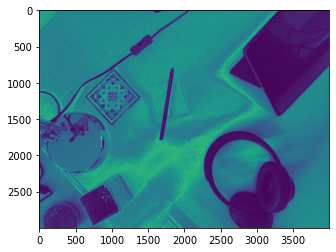

In [45]:
plt.imshow(np.array(df.bytes[0]).reshape((3000,4000,2))[:,:,0])